In [ ]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Object Detection with Torch-TensorRT (SSD)

---
## Overview


In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable.

Torch-TensorRT is a compiler that uses TensorRT (NVIDIA's Deep Learning Optimization SDK and Runtime) to optimize TorchScript code. It compiles standard TorchScript modules into ones that internally run with TensorRT optimizations.

TensorRT can take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family, and Torch-TensorRT enables us to continue to remain in the PyTorch ecosystem whilst doing so. This allows us to leverage the great features in PyTorch, including module composability, its flexible tensor implementation, data loaders and more. Torch-TensorRT is available to use with both PyTorch and LibTorch. 

To get more background information on this, we suggest the **lenet-getting-started** notebook as a primer for getting started with Torch-TensorRT.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with Torch-TensorRT on a pretrained SSD network, and running it to test the speedup obtained.

## Contents
1. [Requirements](#1)
2. [SSD Overview](#2)
3. [Creating TorchScript modules](#3)
4. [Compiling with Torch-TensorRT](#4)
5. [Running Inference](#5)
6. [Measuring Speedup](#6)
7. [Conclusion](#7)

---
<a id="1"></a>
## 1. Requirements

Follow the steps in `notebooks/README` to prepare a Docker container, within which you can run this demo notebook.

In addition to that, run the following cell to obtain additional libraries specific to this demo.

In [1]:
# Known working versions
!pip install numpy==1.21.2 scipy==1.5.2 Pillow==6.2.0 scikit-image==0.17.2 matplotlib==3.3.0
!pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


---
<a id="2"></a>
## 2. SSD

### Single Shot MultiBox Detector model for object detection

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our SSD model pretrained on [COCO](https://cocodataset.org/#home) from there.

### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

More information about this SSD model is available at Nvidia's "DeepLearningExamples" Github [here](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD).

In [2]:
import torch
torch.cuda.set_device(2)
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

In [3]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_gpunet',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [4]:
# load SSD model pretrained on COCO from Torch Hub
precision = 'fp32'
ssd300 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision);

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Setting `precision="fp16"` will load a checkpoint trained with mixed precision 
into architecture enabling execution on Tensor Cores. Handling mixed precision data requires the Apex library.

### Sample Inference

We can now run inference on the model. This is demonstrated below using sample images from the COCO 2017 Validation set.

In [5]:
# Sample images from the COCO validation set
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
# Next, we run object detection
model = ssd300.eval().to("cuda")
detections_batch = model(tensor)

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

### Visualize results

In [7]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# The utility plots the images and predicted bounding boxes (with confidence scores).
def plot_results(best_results):
    for image_idx in range(len(best_results)):
        fig, ax = plt.subplots(1)
        # Show original, denormalized image...
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


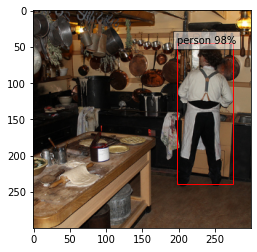

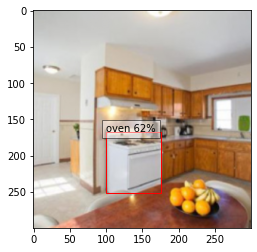

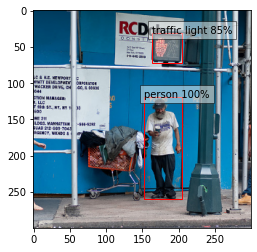

In [8]:
# Visualize results without Torch-TensorRT
plot_results(best_results_per_input)

### Benchmark utility

In [9]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))


We check how well the model performs **before** we use Torch-TensorRT

In [10]:
# Model benchmark without Torch-TensorRT
model = ssd300.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 426.33 ms
Iteration 20/100, avg batch time 426.28 ms
Iteration 30/100, avg batch time 426.31 ms
Iteration 40/100, avg batch time 426.29 ms
Iteration 50/100, avg batch time 426.31 ms
Iteration 60/100, avg batch time 426.29 ms
Iteration 70/100, avg batch time 426.28 ms
Iteration 80/100, avg batch time 426.27 ms
Iteration 90/100, avg batch time 426.27 ms
Iteration 100/100, avg batch time 426.26 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 426.26 ms


---
<a id="3"></a>
## 3. Creating TorchScript modules  

To compile with Torch-TensorRT, the model must first be in **TorchScript**. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: **Tracing** and **Scripting**. <br>
- Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. <br>
- Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. 

Tracing however due to its simplicity is more likely to compile successfully with Torch-TensorRT (though both systems are supported).

In [14]:
model = ssd300.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])

If required, we can also save this model and use it independently of Python.

In [15]:
# This is just an example, and not required for the purposes of this demo
torch.jit.save(traced_model, "ssd_300_traced.jit.pt")

In [16]:
# Obtain the average time taken by a batch of input with Torchscript compiled modules
benchmark(traced_model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 425.25 ms
Iteration 20/100, avg batch time 425.31 ms
Iteration 30/100, avg batch time 425.28 ms
Iteration 40/100, avg batch time 425.27 ms
Iteration 50/100, avg batch time 425.24 ms
Iteration 60/100, avg batch time 425.22 ms
Iteration 70/100, avg batch time 425.23 ms
Iteration 80/100, avg batch time 425.22 ms
Iteration 90/100, avg batch time 425.23 ms
Iteration 100/100, avg batch time 425.23 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 425.23 ms


---
<a id="4"></a>
## 4. Compiling with Torch-TensorRT
TorchScript modules behave just like normal PyTorch modules and are intercompatible. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT.

In [17]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((3, 3, 300, 300), dtype=torch.half)],
    "enabled_precisions": {torch.half}, # Run with FP16
    "workspace_size": 1 << 20
})

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True

---
<a id="5"></a>
## 5. Running Inference

Next, we run object detection

In [18]:
# using a Torch-TensorRT module is exactly the same as how we usually do inference in PyTorch i.e. model(inputs)
detections_batch = trt_model(tensor.to(torch.half)) # convert the input to half precision

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input_trt = [utils.pick_best(results, 0.40) for results in results_per_input]

 undefined behavior using dynamic shape and aten::size


Now, let's visualize our predictions!


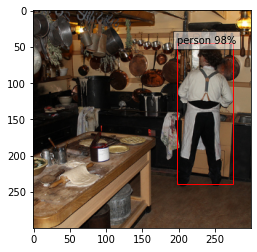

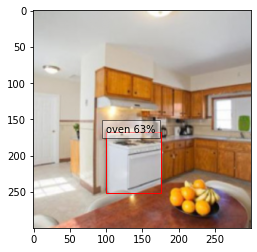

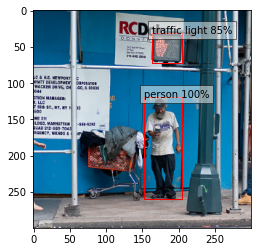

In [19]:
# Visualize results with Torch-TensorRT
plot_results(best_results_per_input_trt)

We get similar results as before!

---
## 6. Measuring Speedup
We can run the benchmark function again to see the speedup gained! Compare this result with the same batch-size of input in the case without Torch-TensorRT above.

In [20]:
batch_size = 128

# Recompiling with batch_size we use for evaluating performance
trt_model = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((batch_size, 3, 300, 300), dtype=torch.half)],
    "enabled_precisions": {torch.half}, # Run with FP16
    "workspace_size": 1 << 20
})

benchmark(trt_model, input_shape=(batch_size, 3, 300, 300), dtype='fp16', nruns=100)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True


Warm up ...
Start timing ...
Iteration 10/100, avg batch time 82.50 ms
Iteration 20/100, avg batch time 82.53 ms
Iteration 30/100, avg batch time 82.55 ms
Iteration 40/100, avg batch time 82.58 ms
Iteration 50/100, avg batch time 82.57 ms
Iteration 60/100, avg batch time 82.56 ms
Iteration 70/100, avg batch time 82.55 ms
Iteration 80/100, avg batch time 82.67 ms
Iteration 90/100, avg batch time 82.65 ms
Iteration 100/100, avg batch time 82.70 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 82.70 ms


---
## 7. Conclusion

In this notebook, we have walked through the complete process of compiling a TorchScript SSD300 model with Torch-TensorRT, and tested the performance impact of the optimization. We find that using the Torch-TensorRT compiled model, we gain significant speedup in inference without any noticeable drop in performance!

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### References

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)